In [40]:
# Step 1: Load the necessary libraries
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import mixed_precision
import os
from tqdm import tqdm  # For progress tracking


In [71]:
# Paths 




# Path to dataset
train_images_path = r"C:\Users\71589\Desktop\train\train"
train_labels_path = r"C:\Users\71589\Desktop\trainLabels.csv"

# Load the labels CSV
labels_df = pd.read_csv(train_labels_path)

# Display the first few rows of the labels dataframe
print(labels_df)
print("Number of unique classes:", labels_df['label'].nunique())


          id       label
0          1        frog
1          2       truck
2          3       truck
3          4        deer
4          5  automobile
...      ...         ...
49995  49996        bird
49996  49997        frog
49997  49998       truck
49998  49999  automobile
49999  50000  automobile

[50000 rows x 2 columns]
Number of unique classes: 10


In [66]:
# Load labels
labels_df = pd.read_csv(train_labels_path)

In [67]:
labels_df

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
...,...,...
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile


In [72]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Initialize arrays for images and labels
images = []
labels = []
missing_files = []

# Load and preprocess images
for idx, row in tqdm(labels_df.iterrows(), total=labels_df.shape[0]):
    img_path = os.path.join(train_images_path, str(row['id']) + '.png')  # Adjust extension if needed
    if os.path.exists(img_path):
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=(32, 32))  # Resize to CIFAR-10 size
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            images.append(img_array)
            labels.append(row['label'])
        except Exception as e:
            print(f"Error loading file {img_path}: {e}")
    else:
        missing_files.append(img_path)

# Debug: Print missing files if any
if missing_files:
    print(f"Missing files ({len(missing_files)}):", missing_files[:10])  # Show first 10 missing files

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Debugging outputs
print(f"Number of images loaded: {len(images)}")
if len(images) > 0:
    print(f"Shape of images array: {images.shape}")
else:
    print("No images were loaded. Please check the file paths.")

100%|██████████| 50000/50000 [19:59<00:00, 41.69it/s]


Number of images loaded: 50000
Shape of images array: (50000, 32, 32, 3)


In [81]:
from tensorflow.keras.utils import to_categorical

# Map labels to integers
unique_labels = np.unique(labels)  # Get unique labels
label_map = {label: idx for idx, label in enumerate(unique_labels)}  # Create a mapping
labels_encoded = np.array([label_map[label] for label in labels])  # Convert labels to integers

# One-hot encode the labels
labels_categorical = to_categorical(labels_encoded, num_classes=len(unique_labels))

# Debugging outputs
print(f"Unique labels: {unique_labels}")
print(f"Encoded labels shape: {labels_encoded.shape}")
print(f"One-hot encoded labels shape: {labels_categorical.shape}")


Unique labels: ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']
Encoded labels shape: (50000,)
One-hot encoded labels shape: (50000, 10)


In [82]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Display shapes of the splits
print(f"Training set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Test set: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Training set: X_train shape: (40000, 32, 32, 3), y_train shape: (40000, 10)
Test set: X_test shape: (10000, 32, 32, 3), y_test shape: (10000, 10)


In [83]:
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # (40000, 3072)
X_test_flat = X_test.reshape(X_test.shape[0], -1)    # (10000, 3072)

print(f"Flattened training set: {X_train_flat.shape}")
print(f"Flattened test set: {X_test_flat.shape}")


Flattened training set: (40000, 3072)
Flattened test set: (10000, 3072)


In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Initialize the model
model_nn = Sequential()

# Input Layer (with 3072 input nodes, corresponding to the flattened image size)
model_nn.add(Dense(512, activation='relu', input_shape=(3072,)))
model_nn.add(Dropout(0.5))  # Dropout for regularization

# Additional Hidden Layers
model_nn.add(Dense(512, activation='relu'))  # New dense layer
model_nn.add(Dropout(0.5))  # Dropout for regularization

model_nn.add(Dense(256, activation='relu'))
model_nn.add(Dropout(0.5))

# Output Layer (10 output nodes for 10 classes, with softmax activation)
model_nn.add(Dense(10, activation='softmax'))

# Compile the model
model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_nn.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,969,930 (7.51 MB)

 Trainable params: 1,969,930 (7.51 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# Train the model
history = model_nn.fit(X_train_flat, y_train, epochs=20, batch_size=64, validation_data=(X_test_flat, y_test))

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2306 - loss: 2.0250 - val_accuracy: 0.2618 - val_loss: 2.0271
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.2313 - loss: 2.0237 - val_accuracy: 0.2580 - val_loss: 2.0433
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.2268 - loss: 2.0263 - val_accuracy: 0.2385 - val_loss: 2.0397
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.2311 - loss: 2.0155 - val_accuracy: 0.2335 - val_loss: 2.0314
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.2310 - loss: 2.0195 - val_accuracy: 0.2611 - val_loss: 2.0086
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.2337 - loss: 2.0191 - val_accuracy: 0.2193 - val_loss: 2.0608
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.2359 - loss: 2.0217 - val_accuracy: 0.2434 - val_loss: 2.0296
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.2294 - loss: 2.0190 - 

In [91]:
# Evaluate on the test set
test_loss, test_accuracy = model_nn.evaluate(X_test_flat, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

313/313 - 1s - 4ms/step - accuracy: 0.2580 - loss: 2.0110
Test Accuracy: 25.80%


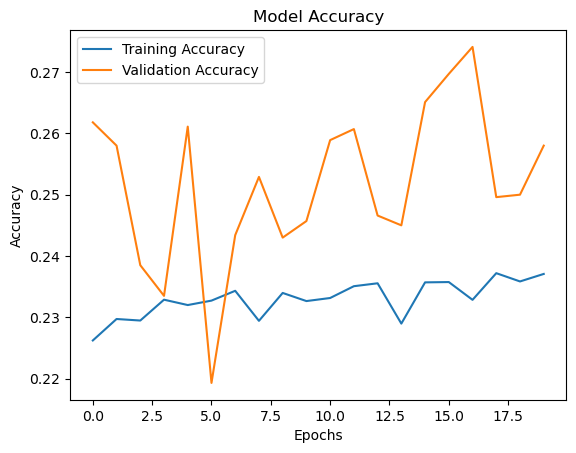

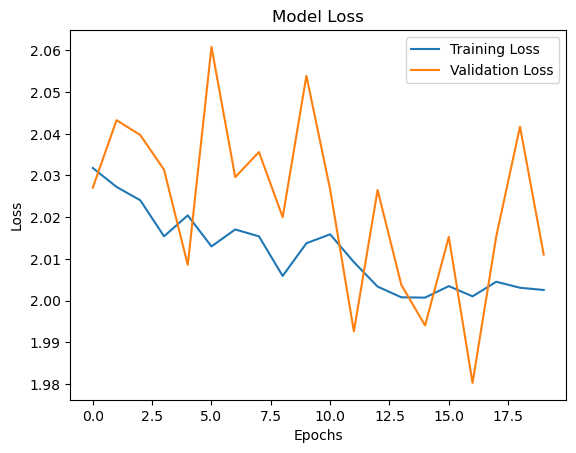

In [92]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


#### CNNtest_accuracy_cnn * 100:.2f}%")


In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model_cnn = Sequential([
    # Convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten layer
    Flatten(),

    # Fully connected (Dense) layers
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularization

    # Output layer
    Dense(10, activation='softmax')
])

# Compile the CNN model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
history_cnn = model_cnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the CNN model
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test, y_test)
print(f"CNN Test Accuracy: {test_accuracy_cnn * 100:.2f}%")


C:\Users\71589\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.2824 - loss: 1.9378 - val_accuracy: 0.5149 - val_loss: 1.3790
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.4800 - loss: 1.4324 - val_accuracy: 0.5480 - val_loss: 1.2645
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5427 - loss: 1.2826 - val_accuracy: 0.5953 - val_loss: 1.1309
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5841 - loss: 1.1756 - val_accuracy: 0.6160 - val_loss: 1.1014
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6065 - loss: 1.1089 - val_accuracy: 0.6471 - val_loss: 1.0055
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.6263 - loss: 1.0611 - val_accuracy: 0.6610 - val_loss: 0.9610
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.6503 - loss: 0.9984 - val_accuracy: 0.6660 - val_loss: 0.9399
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.6673 - loss: 0.9466 - 

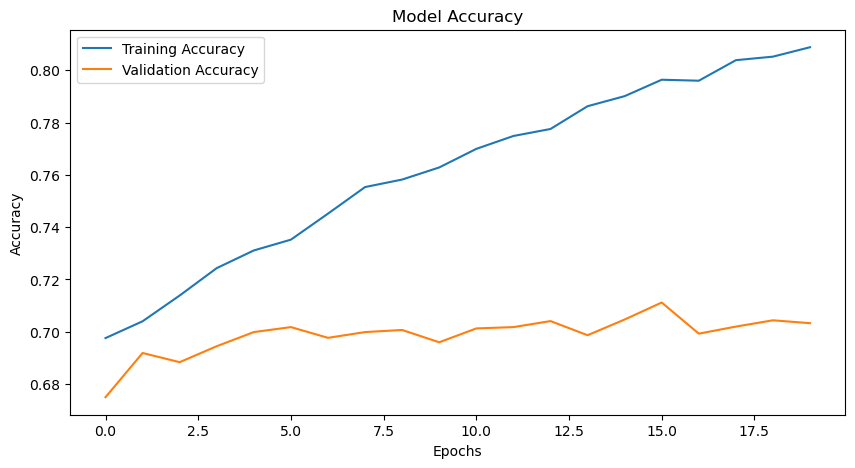

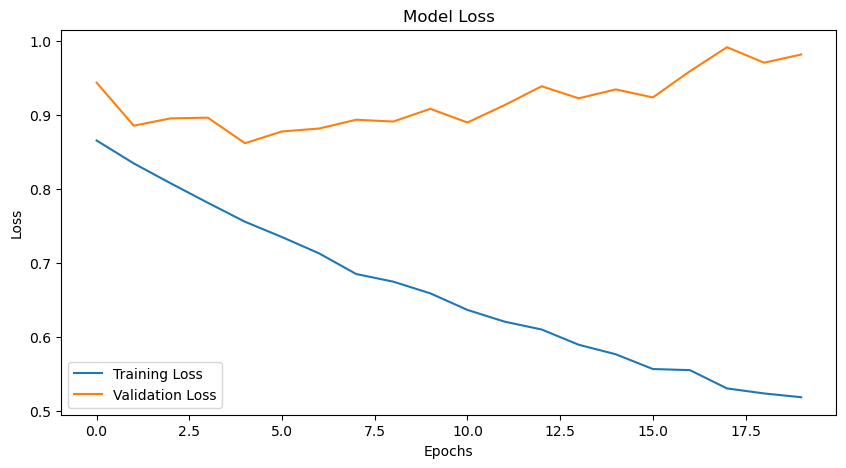

In [95]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()